# Semantic segmentation

## Librairies

In [17]:
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from os import listdir
from random import randint
from sklearn.model_selection import train_test_split
from time import time
from copy import deepcopy
from torch import nn

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [1]:
!pip install segmentation_models

     |████████████████████████████████| 50 kB 2.8 MB/s eta 0:00:01


In [1]:
!pip install keras==2.3.1
!pip install tensorflow==2.1.0
!pip install keras_applications==1.0.8
!pip install image-classifiers==1.0.0
!pip install efficientnet==1.0.0

     |████████████████████████████████| 377 kB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 4.8 MB/s  eta 0:00:01
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |█████████          ^C           | 117.9 MB 24.1 MB/s eta 0:00:13    |████▋                           | 61.4 MB 55.7 MB/s eta 0:00:07
ERROR: Exception:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/pip/_vendor/resolvelib/resolvers.py", line 171, in _merge_into_criterion
    crit = self.state.criteria[name]
KeyError: 'tensorflow'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/pip/_internal/cli/base_command.py", line 189, in _main
    status = self.run(options, args)
  File "/opt/conda/lib/python3.7/site-packages/pip/_internal/cli/req_command.py", line 178, in wrapp

In [2]:
!pip install tensorflow

In [3]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [4]:
#import keras
import tensorflow as tf
import segmentation_models as sm
#from keras import models
sm.set_framework('tf.keras')
sm.framework()
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

Segmentation Models: using `tf.keras` framework.


In [5]:
from pathlib import Path
path = Path.cwd().parent
Base_Path=path / 'input' / 'breast-ultrasound-images-dataset' / 'Dataset_BUSI_with_GT'
print(Base_Path)
unique_class=[]
for path in os.listdir(Base_Path):
  unique_class.append(path)

print(unique_class)

/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT
['benign', 'normal', 'malignant']


In [6]:
class_index=[unique_class[1],unique_class[0],unique_class[2]]
for c in class_index:
  print(c,"-",class_index.index(c))

normal - 0
benign - 1
malignant - 2


In [7]:
images=[]
masks=[]
labels=[]

for folder in os.listdir(Base_Path):
  class_path=os.path.join(Base_Path,folder)
  for img in os.listdir(class_path):
    if '_mask' not in img:
      img_path=os.path.join(class_path,img)
      mask_path=img_path.replace(".png","_mask.png")
      if os.path.exists(mask_path):
        images.append(img_path)
        masks.append(mask_path)
        labels.append(folder) 

In [8]:
input_images_size=256
channel=1

In [9]:
import cv2
import scipy
import scipy.ndimage


def load_image(img_path):
  img=cv2.imread(img_path,0)
  return img

'''def padding(img,msk):

  size=np.max(img.shape)
  size_mask=np.max(msk.shape)

  offset_x=(size-img.shape[0])//2
  offset_y=(size-img.shape[1])//2

  offset_xmsk=(size_mask-msk.shape[0])//2
  offset_ymsk=(size_mask-msk.shape[1])//2

  blank_image=np.zeros((size,size))
  blank_mask=np.zeros((size_mask,size_mask))

  blank_image[offset_x:offset_x+img.shape[0],offset_y:offset_y+img.shape[1]]=img
  blank_mask[offset_xmsk:offset_xmsk+msk.shape[0],offset_ymsk:offset_ymsk+msk.shape[1]]=msk

  return blank_image,blank_mask'''

def resize_mask(mask):
  new_size=np.array([input_images_size,input_images_size])/mask.shape
  mask=scipy.ndimage.interpolation.zoom(mask,new_size)
  return mask

def resize(img):
  img=cv2.resize(img,(input_images_size,input_images_size))
  return img

def preprocess(img):
  img=img/255.0
  return img

def inverse_preprocess(img):
  img=img*255
  return img


def load_data(img_path,msk_path,label):
  img=load_image(img_path)
  msk=load_image(msk_path)
  #img,msk=padding(img,msk)
  label_indx=class_index.index(label)
  msk[msk==255]=1
  msk=msk.astype('uint8')
  img=resize(img)
  msk=resize_mask(msk)
  new_mask=np.zeros((input_images_size,input_images_size,2))
  if label_indx!=0:
    new_mask[:,:,label_indx-1]=msk
  return img,new_mask


def load_batch(images,mask,labels):
  batch_x=[]
  batch_y=[]
  for i,m,l in zip(images,masks,labels):
    img,msk=load_data(i,m,l)
    img=preprocess(img)
    batch_x.append(img)
    batch_y.append(msk)

  return np.array(batch_x),np.array(batch_y)


2 255 (256, 256)


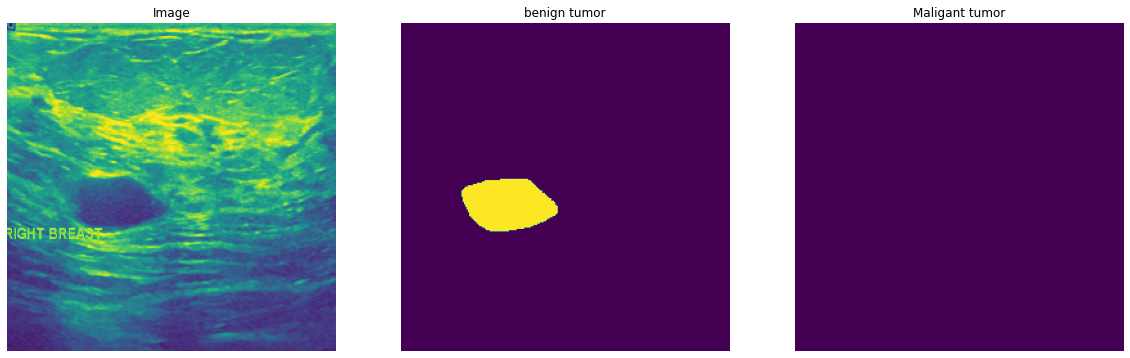

0 253 (256, 256)


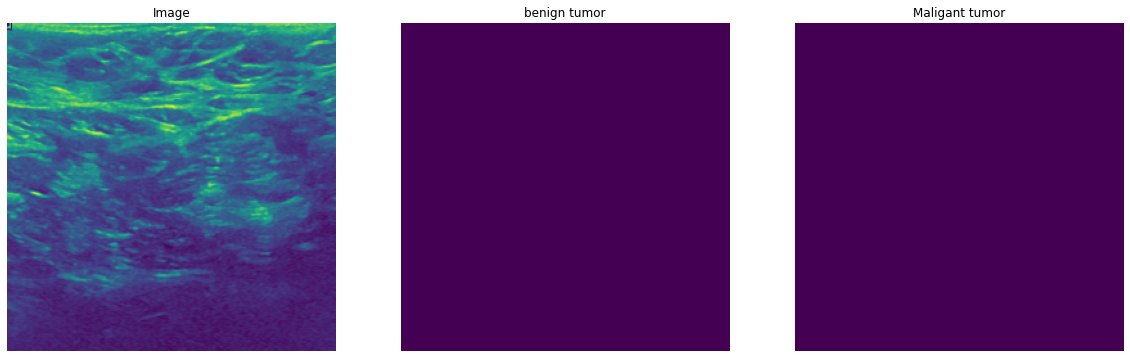

1 255 (256, 256)


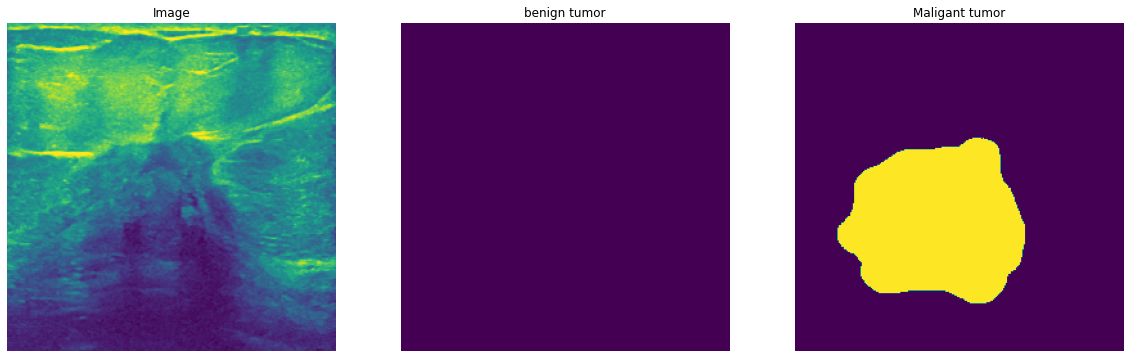

In [10]:
import matplotlib.pyplot as plt


for i in [0,500,600]:
  indx=i
  img,msk=load_data(images[indx],masks[indx],labels[indx])
  print(np.min(img),np.max(img),img.shape)
  plt.figure(figsize=(20,20))
  plt.subplot(1,3,1)
  plt.axis('off')
  plt.imshow(img)
  plt.title("Image")
  plt.subplot(1,3,2)
  plt.axis('off')
  plt.imshow(msk[:,:,0])
  plt.title("benign tumor")
  plt.subplot(1,3,3)
  plt.axis('off')
  plt.imshow(msk[:,:,1])
  plt.title("Maligant tumor")
  plt.show()




In [11]:
images=np.array(images)
masks=np.array(masks)
labels=np.array(labels)

In [12]:
print(tf.__version__)

2.4.1


In [29]:
!pip install tensorflow==2.5.0

     |████████████████████████████████| 454.3 MB 14 kB/s s eta 0:00:01   |█████▎                          | 75.6 MB 7.5 MB/s eta 0:00:51     |██████▎                         | 88.6 MB 7.5 MB/s eta 0:00:49     |████████████████████▍           | 289.7 MB 15.7 MB/s eta 0:00:11     |████████████████████▊           | 294.6 MB 36.1 MB/s eta 0:00:05     |█████████████████████▎          | 301.6 MB 36.1 MB/s eta 0:00:05     |█████████████████████▍          | 303.4 MB 36.1 MB/s eta 0:00:05     |█████████████████████▌          | 305.3 MB 36.1 MB/s eta 0:00:05     |██████████████████████▊         | 322.4 MB 36.1 MB/s eta 0:00:04
     |████████████████████████████████| 4.0 MB 36.8 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 43.3 MB/s eta 0:00:01
     |████████████████████████████████| 6.0 MB 39.2 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 39.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 35.0 MB/s eta 0:00:01
     |████████████████████████

In [ ]:
#from keras.utils import conv_utils, multi_gpu_model

: 

In [13]:
import tensorflow as tf
import segmentation_models as sm
sm.set_framework('tf.keras')



sm.framework()
BACKBONE='resnet34'
LR=0.00001

model=sm.Linknet(BACKBONE,classes=2,activation='sigmoid',input_shape=(input_images_size,input_images_size,channel),encoder_weights=None)
optim=tf.keras.optimizers.Adam(LR)

dice_loss=sm.losses.DiceLoss()
focal_loss=sm.losses.BinaryFocalLoss()
total_loss=dice_loss+(1*focal_loss)




metrics=[sm.metrics.IOUScore(threshold=0.5),
         sm.metrics.FScore(threshold=0.5)]


model.compile(optim,total_loss,metrics)


In [34]:
batch_size=4
history={"epoch":[]}
for e in range(100):
  print("epoch:",e,end=">")
  indexes=list(range(len(images)))
  temp_history={'loss':[],
                'IOU':[],
                'F-Score':[]}
  for b in range(0,len(images),batch_size):
    bs=b
    be=bs+batch_size
    batch_index=indexes[bs:be]
    batch_x, batch_y=load_batch(images[batch_index],masks[batch_index],labels[batch_index])
    batch_x=np.expand_dims(batch_x,axis=-1)
    batch_y=np.expand_dims(batch_y,axis=-1)
    batch_y=batch_y.astype("float32")
    loss=model.train_on_batch(batch_x,batch_y)
    temp_history['loss'].append(loss[0])
    temp_history['IOU'].append(loss[1])
    temp_history['F-Score'].append(loss[2])
  
  print("loss",np.round(np.mean(temp_history['loss']),4),
        "IOU",np.round(np.mean(temp_history['IOU']),4),
        "F-score",np.round(np.mean(temp_history['F-Score']),4))
  
  history['epoch'].append("temp_history")



epoch: 0>loss 0.7326 IOU 0.3803 F-score 0.3982
epoch: 1>loss 0.7237 IOU 0.3873 F-score 0.4032
epoch: 2>loss 0.7164 IOU 0.391 F-score 0.4064
epoch: 3>loss 0.7095 IOU 0.3869 F-score 0.4018
epoch: 4>loss 0.7029 IOU 0.3975 F-score 0.4122
epoch: 5>loss 0.696 IOU 0.3924 F-score 0.406
epoch: 6>loss 0.6892 IOU 0.4023 F-score 0.4148
epoch: 7>loss 0.6835 IOU 0.4108 F-score 0.4229
epoch: 8>loss 0.6779 IOU 0.4317 F-score 0.4437
epoch: 9>loss 0.6727 IOU 0.4451 F-score 0.4568
epoch: 10>loss 0.6686 IOU 0.4846 F-score 0.497
epoch: 11>loss 0.6639 IOU 0.493 F-score 0.5051
epoch: 12>loss 0.6593 IOU 0.4788 F-score 0.4903
epoch: 13>loss 0.6549 IOU 0.5671 F-score 0.5781
epoch: 14>loss 0.6506 IOU 0.568 F-score 0.5786
epoch: 15>loss 0.6468 IOU 0.5558 F-score 0.566
epoch: 16>loss 0.643 IOU 0.5777 F-score 0.5873
epoch: 17>loss 0.6403 IOU 0.6639 F-score 0.674
epoch: 18>loss 0.637 IOU 0.6746 F-score 0.6845
epoch: 19>loss 0.6339 IOU 0.6006 F-score 0.6103
epoch: 20>loss 0.6313 IOU 0.5927 F-score 0.6025
epoch: 21>lo

In [18]:
batch_size=4
history={"epoch":[]}
for e in range(25):
  print("epoch:",e,end=">")
  indexes=list(range(len(images)))
  temp_history={'loss':[],
                'IOU':[],
                'F-Score':[]}
  for b in range(0,len(images),batch_size):
    bs=b
    be=bs+batch_size
    batch_index=indexes[bs:be]
    batch_x, batch_y=load_batch(images[batch_index],masks[batch_index],labels[batch_index])
    batch_x=np.expand_dims(batch_x,axis=-1)
    batch_y=np.expand_dims(batch_y,axis=-1)
    batch_y=batch_y.astype("float32")
    loss=model.train_on_batch(batch_x,batch_y)
    temp_history['loss'].append(loss[0])
    temp_history['IOU'].append(loss[1])
    temp_history['F-Score'].append(loss[2])
  
  print("loss",np.round(np.mean(temp_history['loss']),4),
        "IOU",np.round(np.mean(temp_history['IOU']),4),
        "F-score",np.round(np.mean(temp_history['F-Score']),4))
  
  history['epoch'].append("temp_history")


epoch: 0>loss 0.7177 IOU 0.4593 F-score 0.4763
epoch: 1>loss 0.71 IOU 0.4603 F-score 0.4768
epoch: 2>loss 0.7034 IOU 0.4801 F-score 0.4969
epoch: 3>loss 0.6964 IOU 0.5092 F-score 0.5256
epoch: 4>loss 0.69 IOU 0.5359 F-score 0.5518
epoch: 5>loss 0.6849 IOU 0.4913 F-score 0.5077
epoch: 6>loss 0.6783 IOU 0.584 F-score 0.5991
epoch: 7>loss 0.6728 IOU 0.5804 F-score 0.5947
epoch: 8>loss 0.6676 IOU 0.5456 F-score 0.5594
epoch: 9>loss 0.6628 IOU 0.6054 F-score 0.6189
epoch: 10>loss 0.6588 IOU 0.5619 F-score 0.5753
epoch: 11>loss 0.6538 IOU 0.6206 F-score 0.6329
epoch: 12>loss 0.6493 IOU 0.6687 F-score 0.6802
epoch: 13>loss 0.6456 IOU 0.6387 F-score 0.6498
epoch: 14>loss 0.642 IOU 0.665 F-score 0.6758
epoch: 15>loss 0.6392 IOU 0.6545 F-score 0.6654
epoch: 16>loss 0.6364 IOU 0.7087 F-score 0.7194
epoch: 17>loss 0.6341 IOU 0.639 F-score 0.6499
epoch: 18>loss 0.6316 IOU 0.6672 F-score 0.6781
epoch: 19>loss 0.6299 IOU 0.6071 F-score 0.6186
epoch: 20>loss 0.627 IOU 0.6523 F-score 0.663
epoch: 21>lo

In [21]:
model.save('/kaggle/working/Linknet_model.h5')

In [20]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import keras
from keras import backend as K
from keras import activations, initializers, regularizers, constraints, metrics
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import (Dense, Dropout, Activation, Flatten, Reshape, Layer,
                          BatchNormalization, LocallyConnected2D,
                          ZeroPadding2D, Conv2D, MaxPooling2D, Conv2DTranspose,
                          GaussianNoise, UpSampling2D, Input)
#from keras.utils import conv_utils, multi_gpu_model
from keras.layers import Lambda
from keras.engine import Layer, InputSpec
from keras.legacy import interfaces

0 238 (256, 256)


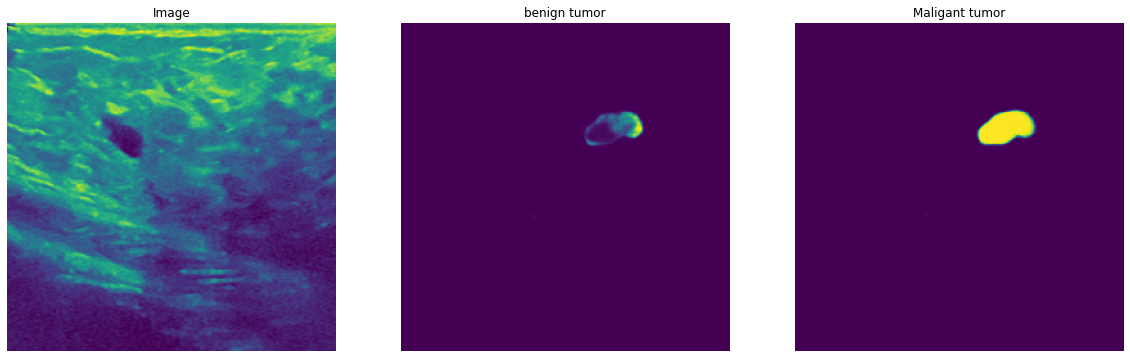

0 255 (256, 256)


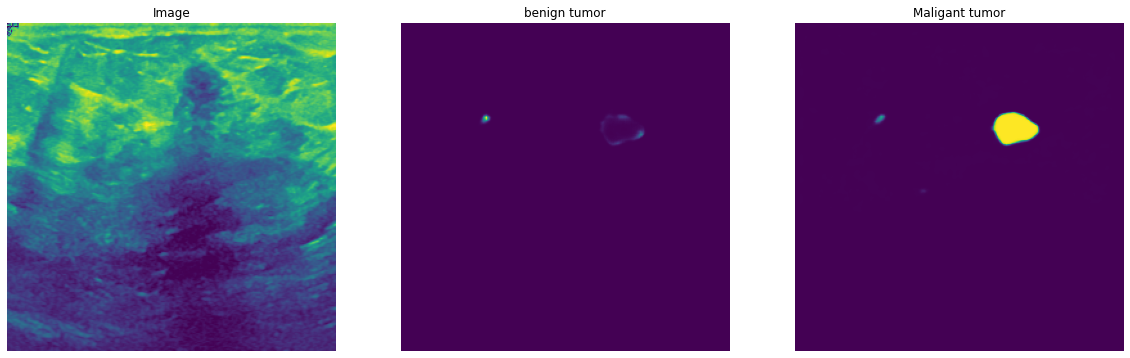

0 255 (256, 256)


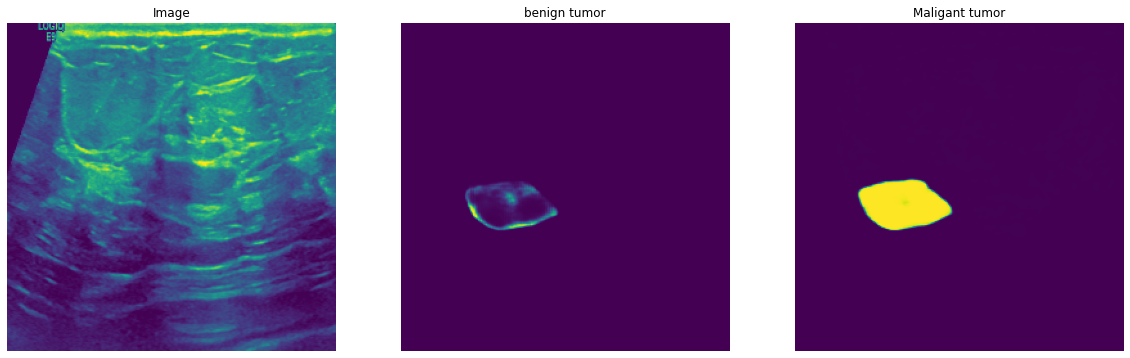

2 239 (256, 256)


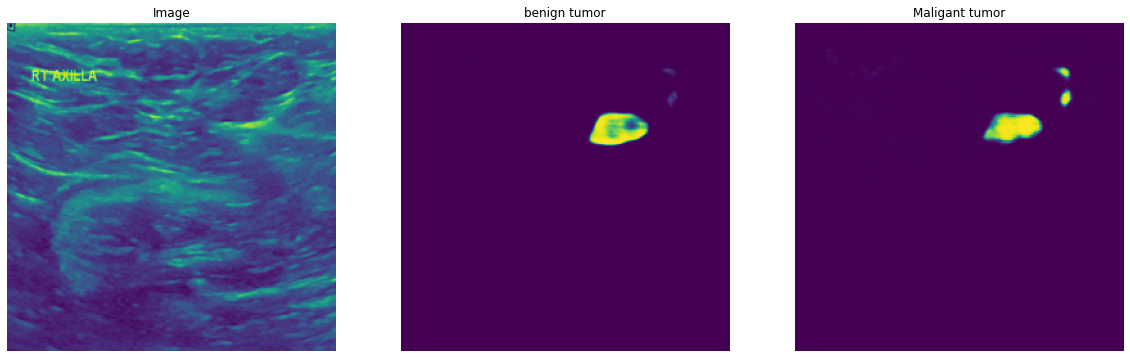

1 255 (256, 256)


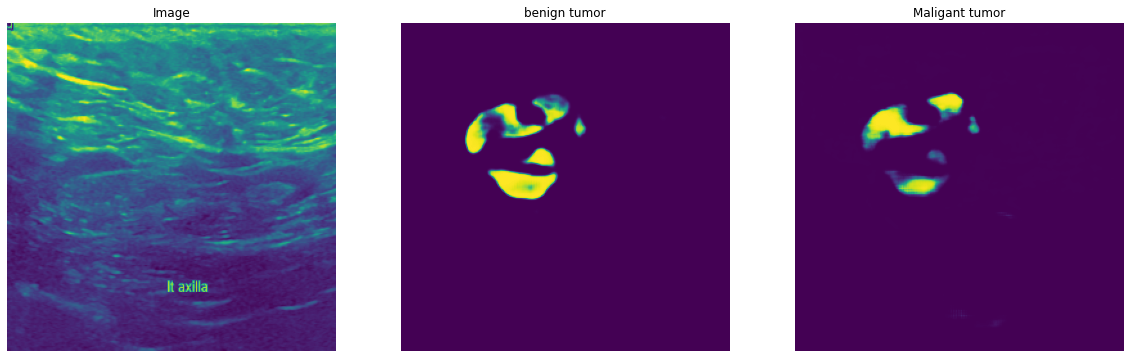

0 255 (256, 256)


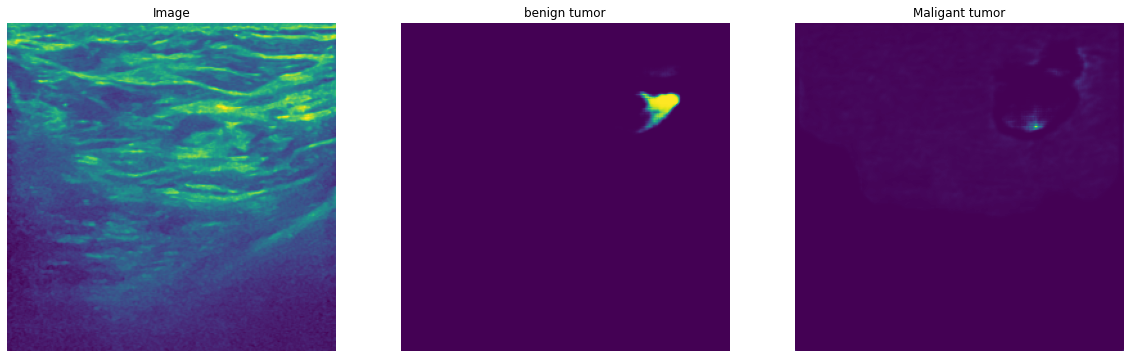

0 255 (256, 256)


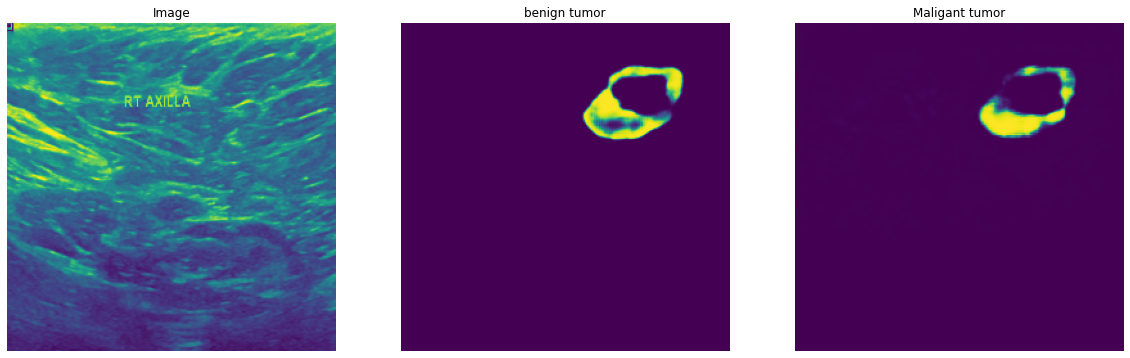

0 255 (256, 256)


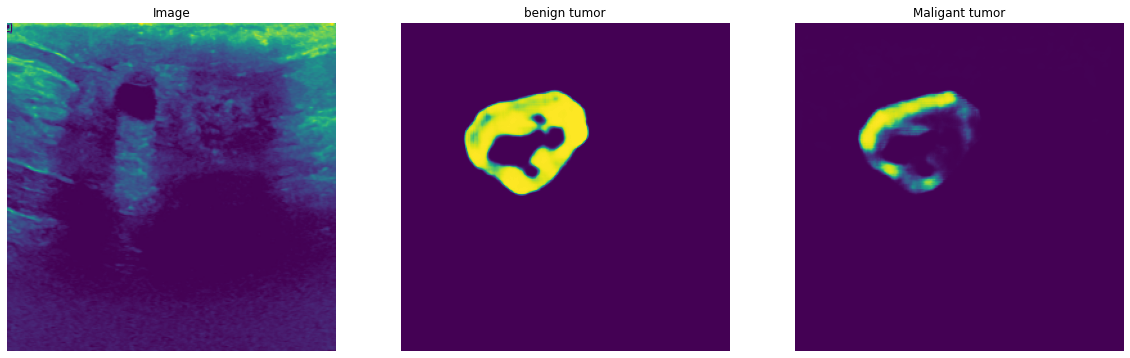

16 227 (256, 256)


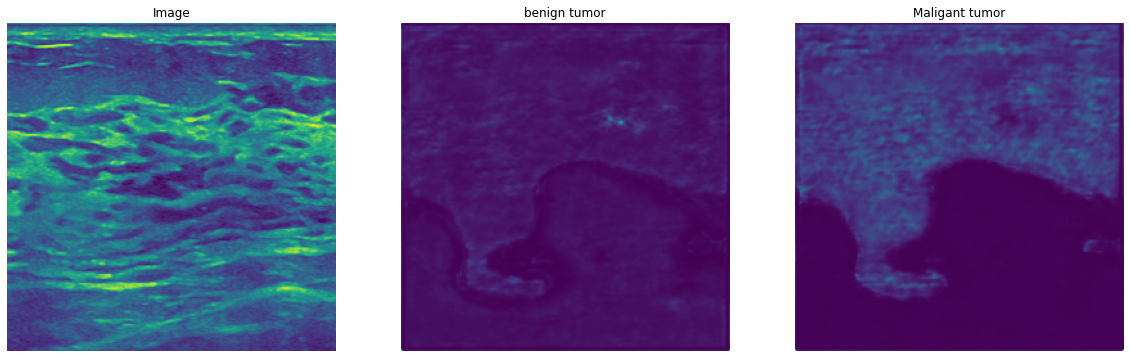

0 253 (256, 256)


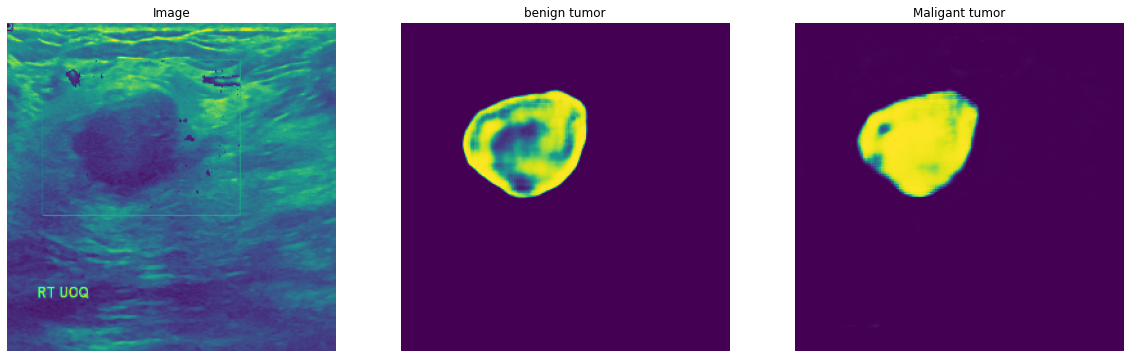

In [37]:
import matplotlib.pyplot as plt

index=np.random.choice(list(range(780)),10)
for i in index:
  indx=i
  img,msk=load_data(images[indx],masks[indx],labels[indx])
  print(np.min(img),np.max(img),img.shape)

  img2=preprocess(img)
  pred=model.predict(np.array([img2]))
  pred=pred[0]

  plt.figure(figsize=(20,20))
  plt.subplot(1,3,1)
  plt.axis('off')
  plt.imshow(img)
  plt.title("Image")
  plt.subplot(1,3,2)
  plt.axis('off')
  plt.imshow(pred[:,:,0])
  plt.title("benign tumor")
  plt.subplot(1,3,3)
  plt.axis('off')
  plt.imshow(pred[:,:,1])
  plt.title("Maligant tumor")
  plt.show()